In [1]:
!unzip "/content/bike-sharing-demand.zip"

Archive:  /content/bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df = pd.concat([df_train, df_test])

* Data Fields
* datetime - hourly date + timestamp  
* season:
 - 1 = spring
 - 2 = summer
 - 3 = fall
 - 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [5]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
df.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
dtype: int64

In [7]:
df.shape

(17379, 12)

In [8]:
df = df.dropna()

In [9]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<ipython-input-10-3a9f600df7ec>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


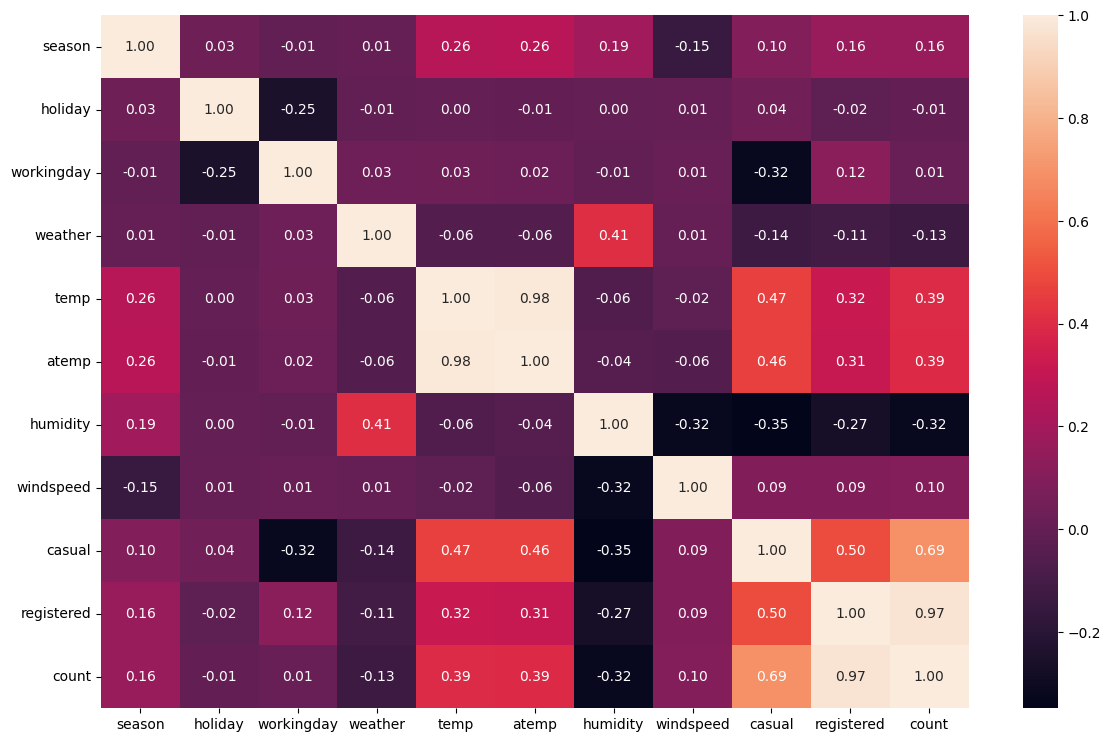

In [10]:
df_corr = df.corr()
plt.figure(figsize=(14,9))
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.show()

In [64]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, mean_squared_error
from sklearn.preprocessing import label_binarize
from itertools import cycle

def generate_matriz_confusion(test_labels, test_predictions_labels):
  cm = confusion_matrix(test_labels, test_predictions_labels)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Rótulos Previstos")
  plt.ylabel("Rótulos Verdadeiros")
  plt.title("Matriz de Confusão")
  plt.show()

In [65]:
def calcule_metrics_classification(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")
  print(f"ROC AUC: {roc_auc}")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")

In [168]:
def plot_auc_ap(y_test, predictions):
  fpr, tpr, _ = roc_curve(y_test, predictions)
  roc_auc = roc_auc_score(y_test, predictions)

  precision, recall, _ = precision_recall_curve(y_test, predictions)
  ap = average_precision_score(y_test, predictions)

  plt.figure(figsize=(10, 5))

  # Curva ROC
  plt.subplot(1, 2, 1)
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('Taxa de Falso Positivo')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('Curva ROC')
  plt.legend(loc='lower right')

  # Curva Precision-Recall
  plt.subplot(1, 2, 2)
  plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap:.2f}')
  plt.xlabel('Revocação (Recall)')
  plt.ylabel('Precisão (Precision)')
  plt.title('Curva Precision-Recall')
  plt.legend(loc='lower left')

  plt.tight_layout()
  plt.show()

In [169]:
def train_and_metrics(model, X_train, y_train, X_test, y_test):
  all_predictions = []
  all_true_labels = []

  all_accuracy = []
  all_precision = []
  all_recall = []
  all_f1 = []
  all_roc_auc = []

  best_metric_value = -np.inf
  best_model = None

  cv = KFold(n_splits = 5, shuffle=True, random_state = 42)
  for n_folder, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
      X_train_fold, X_valid = X.iloc[train_index], X.iloc[test_index]
      y_train_fold, y_valid = y.iloc[train_index], y.iloc[test_index]

      model.fit(X_train_fold, y_train_fold)

      predictions = model.predict(X_valid)

      print(f'\nMatriz de confusão para o folder {n_folder}')
      generate_matriz_confusion(y_valid, predictions)

      accuracy = accuracy_score(y_valid, predictions)
      precision = precision_score(y_valid, predictions)
      recall = recall_score(y_valid, predictions)
      f1 = f1_score(y_valid, predictions)
      roc_auc = roc_auc_score(y_valid, predictions)

      print(f"Accuracy: {accuracy}")
      print(f"Precision: {precision}")
      print(f"Recall: {recall}")
      print(f"F1-score: {f1}")
      print(f"ROC AUC: {roc_auc}")

      all_accuracy.append(accuracy)
      all_precision.append(precision)
      all_recall.append(recall)
      all_f1.append(f1)
      all_roc_auc.append(roc_auc)

      if accuracy > best_metric_value:
          best_metric_value = accuracy
          best_model = model

      all_predictions.extend(predictions)
      all_true_labels.extend(y_valid)

  accuracy = accuracy_score(all_true_labels, all_predictions)
  precision = precision_score(all_true_labels, all_predictions)
  recall = recall_score(all_true_labels, all_predictions)
  f1 = f1_score(all_true_labels, all_predictions)
  roc_auc = roc_auc_score(all_true_labels, all_predictions)

  print('\n--------Métricas gerais (média) para a predição dos 5 folders--------:')
  calcule_metrics_classification(all_true_labels, all_predictions)

  predictions = best_model.predict(X_test)
  generate_matriz_confusion(y_test, predictions)
  print('\n--------Cálculo das métricas do melhor modelo--------:')
  calcule_metrics_classification(y_test, predictions)
  print()

  plot_auc_ap(y_test, predictions)
  print()

  return best_model

# Processamento dos dados

In [170]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

In [171]:
columns = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'registered', 'casual']
columns = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'day', 'hour', 'registered', 'casual']

In [172]:
X = df[columns]
y = df['count']

# Classificação

> Classificando quando será alugado 150 ou mais bicicletas no dia



In [173]:
df['count'].value_counts()

5.0      169
4.0      149
3.0      144
6.0      135
2.0      132
        ... 
801.0      1
629.0      1
825.0      1
589.0      1
636.0      1
Name: count, Length: 822, dtype: int64

In [174]:
max(df['count']), min(df['count'])

(977.0, 1.0)

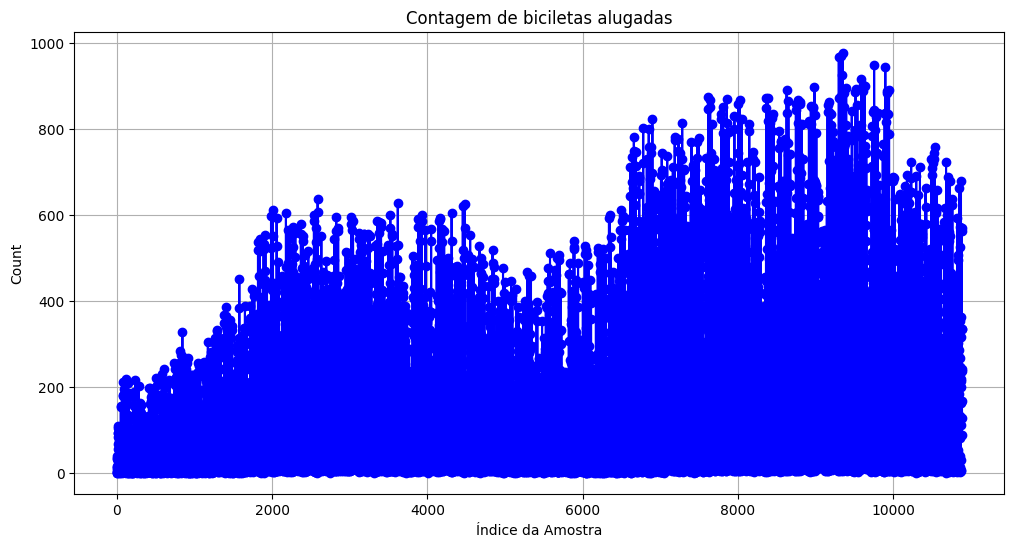

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(df['count'], marker='o', linestyle='-', color='b')
plt.title('Contagem de biciletas alugadas')
plt.xlabel('Índice da Amostra')
plt.ylabel('Count')
plt.grid(True)

plt.show()

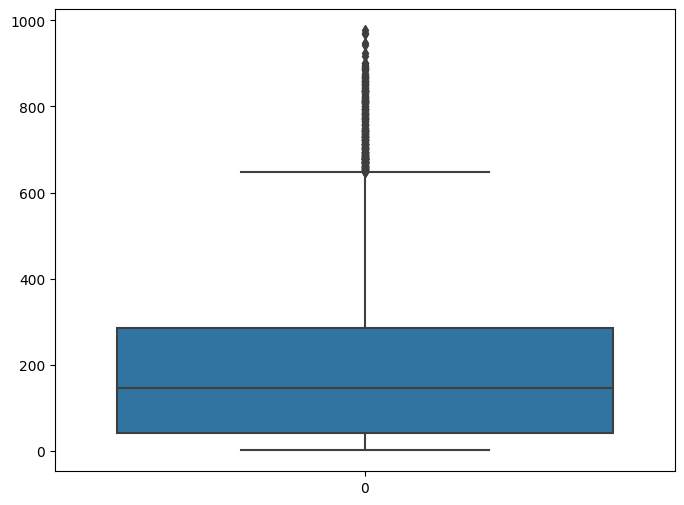

In [176]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df['count'], orient="v")
plt.show()

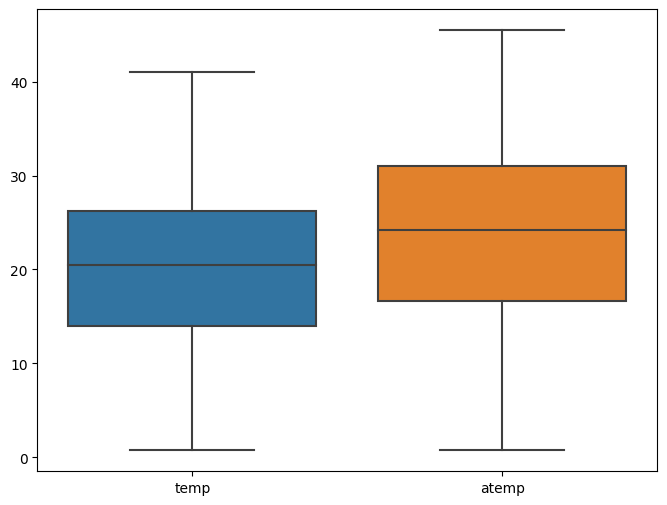

In [177]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[['temp','atemp']],
            orient='v')
plt.show()

> Queremos construir um modelo que faça a predição se em determinado dia serão alugadas mais de 50% da média de bicicletas: 287 bicicletas

In [178]:
limiar = 287
df['demand_class'] = (df['count'] > limiar).astype(int)

columns_classification = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'day', 'hour', 'registered', 'casual']
X = df[columns_classification]
y = df['demand_class']

In [179]:
df = df.dropna()

In [180]:
y.value_counts()

0    8226
1    2660
Name: demand_class, dtype: int64

In [181]:
X.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
month         0
day           0
hour          0
registered    0
casual        0
dtype: int64

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 456)

In [183]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)

## Random Forest


Matriz de confusão para o folder 0


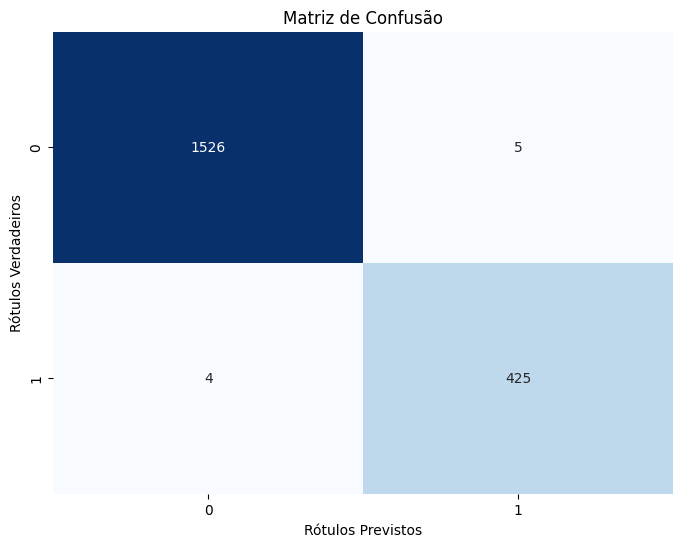

Accuracy: 0.9954081632653061
Precision: 0.9883720930232558
Recall: 0.9906759906759907
F1-score: 0.9895227008149011
ROC AUC: 0.9937050756776425

Matriz de confusão para o folder 1


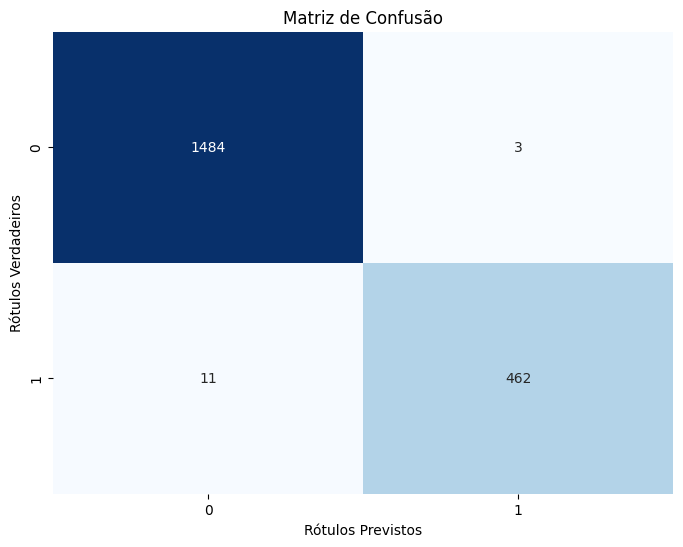

Accuracy: 0.9928571428571429
Precision: 0.9935483870967742
Recall: 0.9767441860465116
F1-score: 0.9850746268656716
ROC AUC: 0.9873633505888241

Matriz de confusão para o folder 2


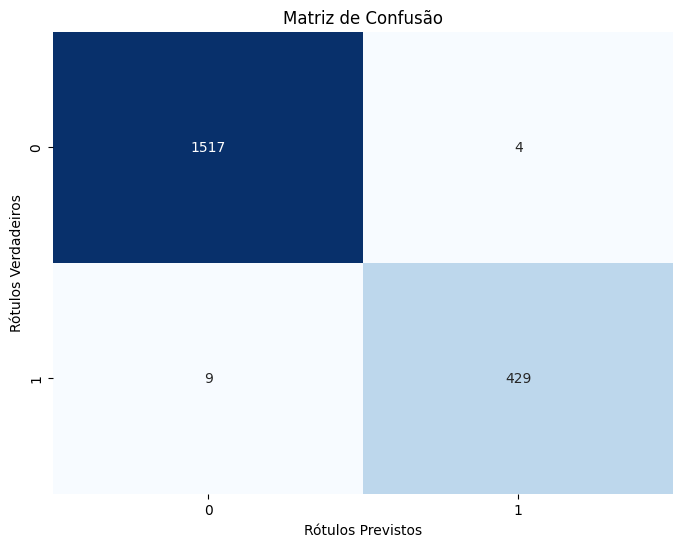

Accuracy: 0.9933639612046963
Precision: 0.9907621247113164
Recall: 0.9794520547945206
F1-score: 0.9850746268656716
ROC AUC: 0.9884111030054128

Matriz de confusão para o folder 3


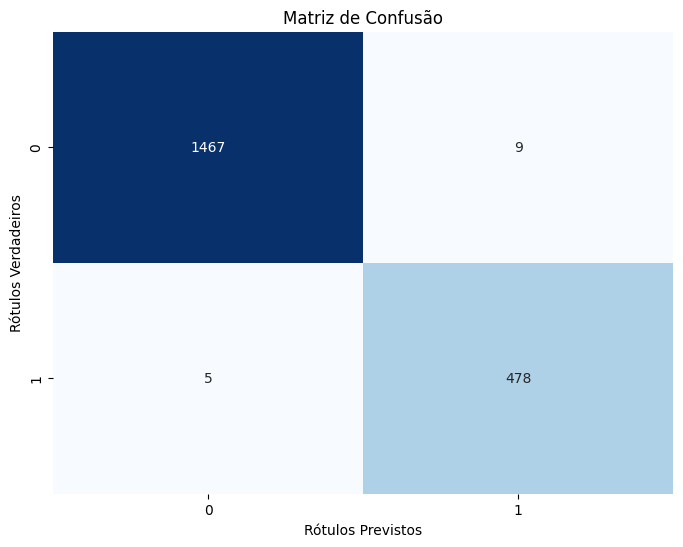

Accuracy: 0.9928534966819806
Precision: 0.9815195071868583
Recall: 0.989648033126294
F1-score: 0.9855670103092783
ROC AUC: 0.9917752360753421

Matriz de confusão para o folder 4


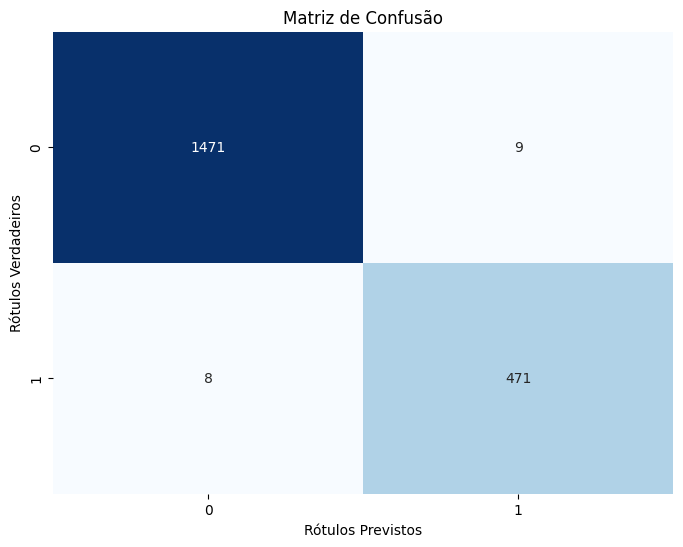

Accuracy: 0.9913221031138336
Precision: 0.98125
Recall: 0.9832985386221295
F1-score: 0.9822732012513035
ROC AUC: 0.9886087287705243

--------Métricas gerais (média) para a predição dos 5 folders--------:
Accuracy: 0.9931611717872818
Precision: 0.9869281045751634
Recall: 0.9839270199826238
F1-score: 0.9854252773547966
ROC AUC: 0.9899621757684965
MSE: 0.006838828212718179
RMSE: 0.08269720801041701


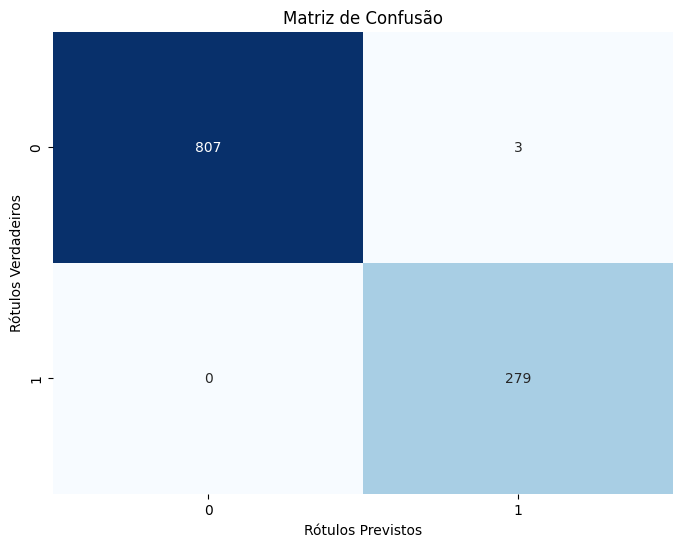


--------Cálculo das métricas do melhor modelo--------:
Accuracy: 0.9972451790633609
Precision: 0.9893617021276596
Recall: 1.0
F1-score: 0.9946524064171123
ROC AUC: 0.9981481481481482
MSE: 0.0027548209366391185
RMSE: 0.0524863881081478



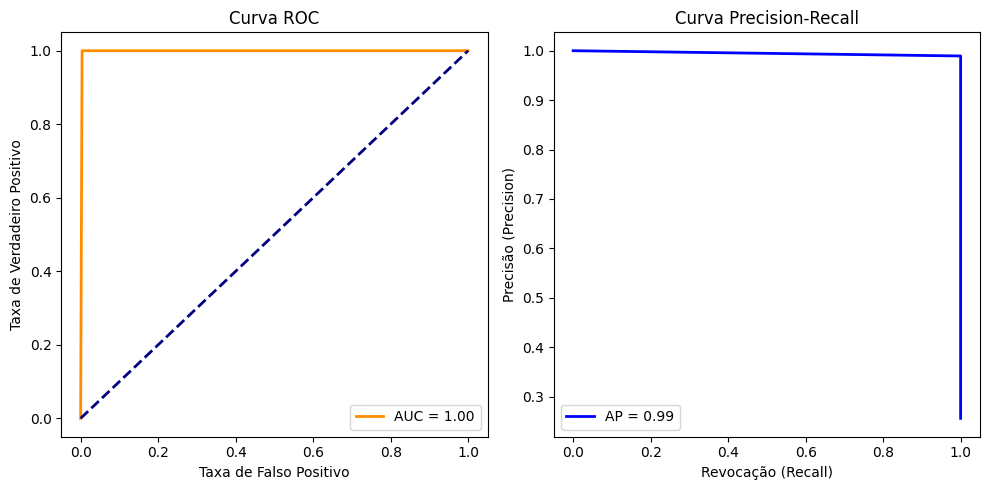

In [184]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 123)
best_rf_model = train_and_metrics(rf_model, X_train, y_train, X_test, y_test)

## SVM


Matriz de confusão para o folder 0


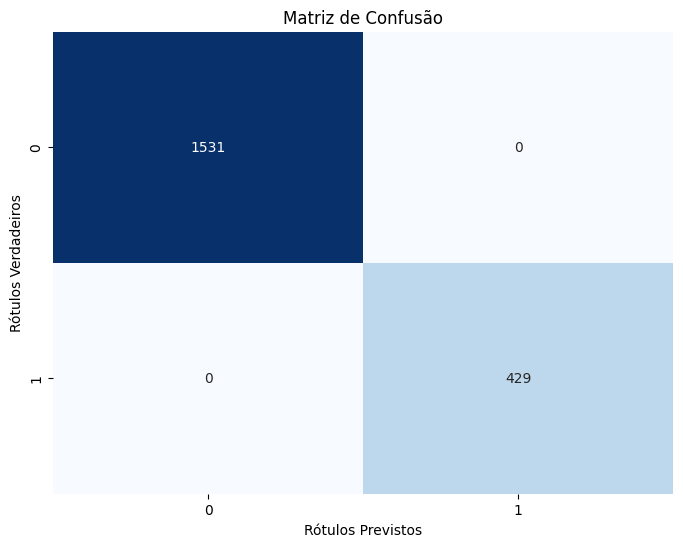

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0

Matriz de confusão para o folder 1


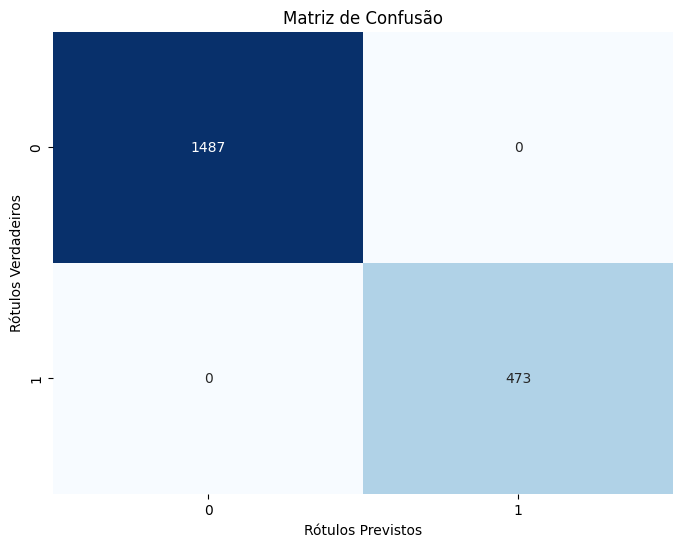

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0

Matriz de confusão para o folder 2


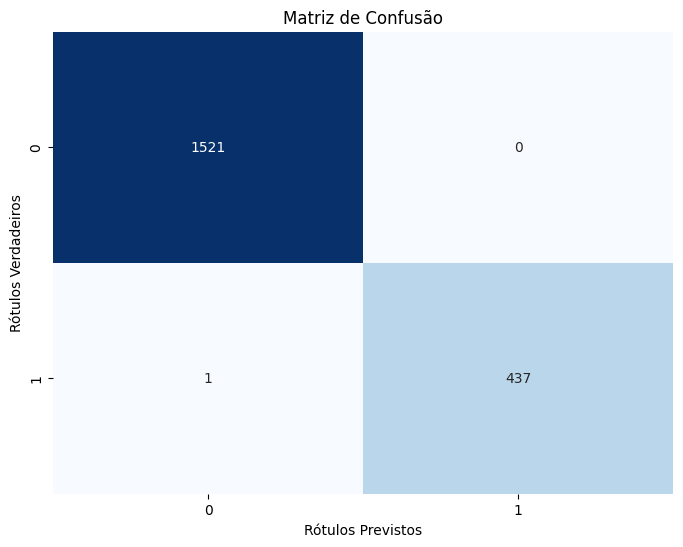

Accuracy: 0.9994895354772844
Precision: 1.0
Recall: 0.997716894977169
F1-score: 0.9988571428571429
ROC AUC: 0.9988584474885844

Matriz de confusão para o folder 3


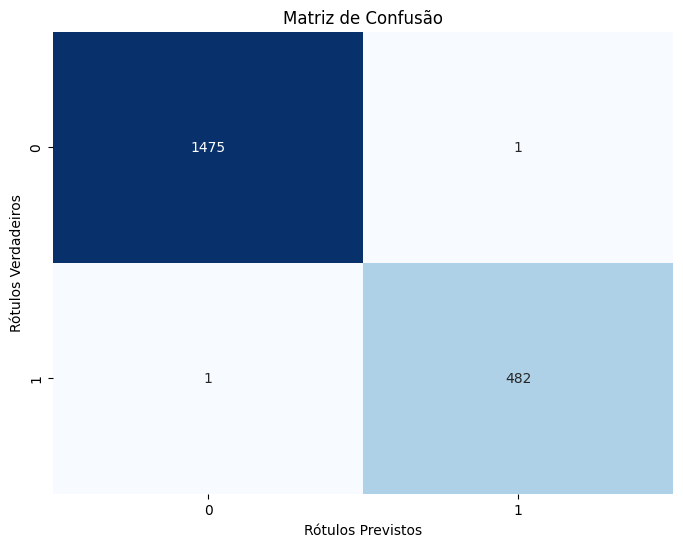

Accuracy: 0.9989790709545686
Precision: 0.9979296066252588
Recall: 0.9979296066252588
F1-score: 0.9979296066252588
ROC AUC: 0.9986260499250955

Matriz de confusão para o folder 4


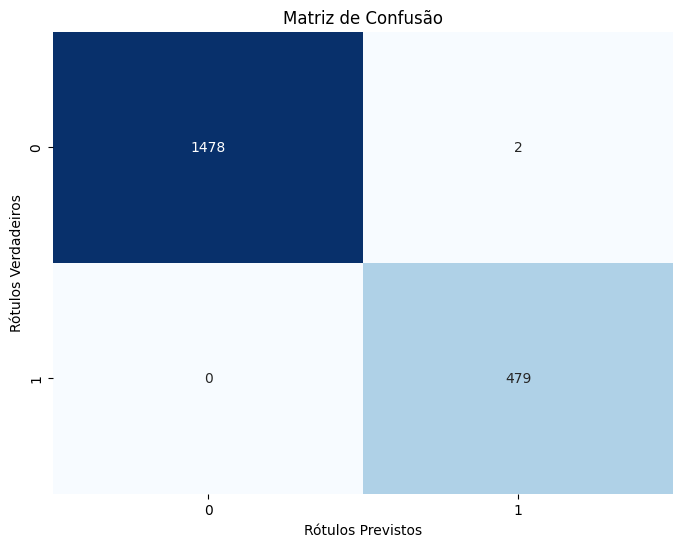

Accuracy: 0.9989790709545686
Precision: 0.9958419958419958
Recall: 1.0
F1-score: 0.9979166666666666
ROC AUC: 0.9993243243243244

--------Métricas gerais (média) para a predição dos 5 folders--------:
Accuracy: 0.999489639685618
Precision: 0.998697351280938
Recall: 0.9991311902693311
F1-score: 0.998914223669924
ROC AUC: 0.9993654617123839
MSE: 0.0005103603143819537
RMSE: 0.022591155667250708


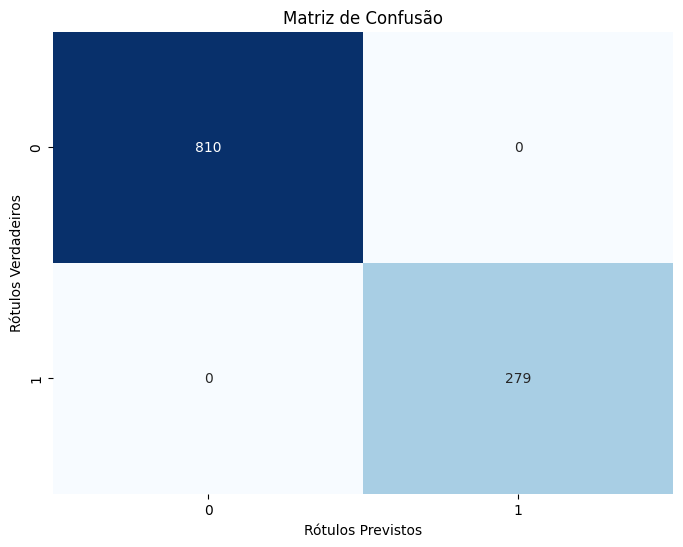


--------Cálculo das métricas do melhor modelo--------:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0
MSE: 0.0
RMSE: 0.0



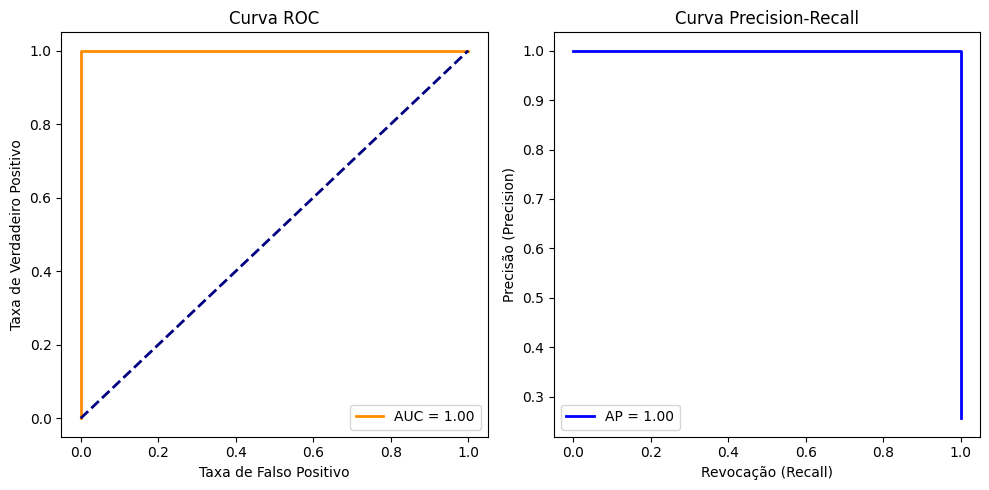

In [185]:
from sklearn.svm import SVC
svc_model = SVC(kernel='linear', C = 1.0, random_state = 548)

best_svc_model = train_and_metrics(svc_model, X_train, y_train, X_test, y_test)

## Rede Neural

### Rede Bayesiana

In [186]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [187]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_normalized = scaler.fit_transform(X_train)


Matriz de confusão para o folder 0


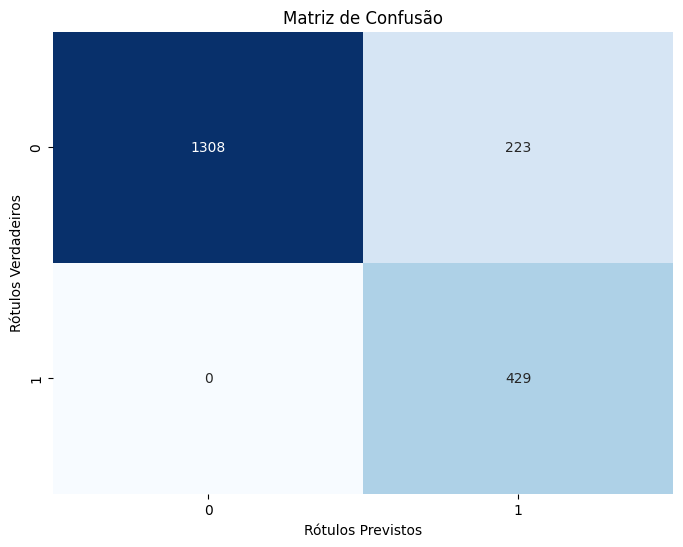

Accuracy: 0.8862244897959184
Precision: 0.6579754601226994
Recall: 1.0
F1-score: 0.793709528214616
ROC AUC: 0.9271717831482691

Matriz de confusão para o folder 1


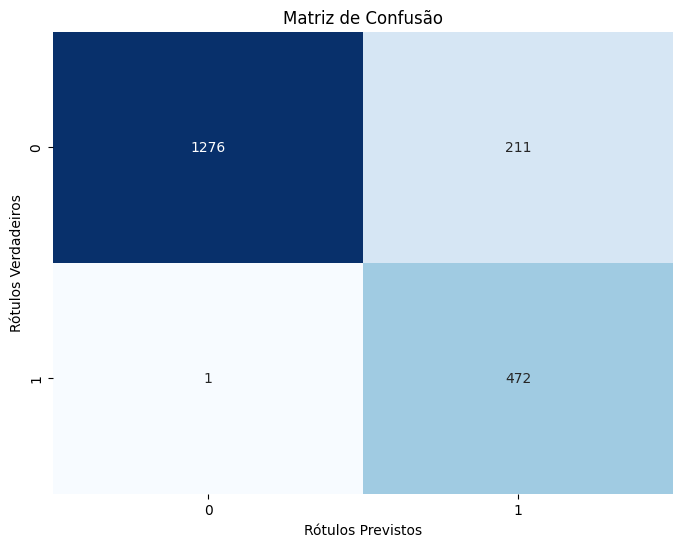

Accuracy: 0.8918367346938776
Precision: 0.6910688140556369
Recall: 0.9978858350951374
F1-score: 0.8166089965397924
ROC AUC: 0.9279946996592029

Matriz de confusão para o folder 2


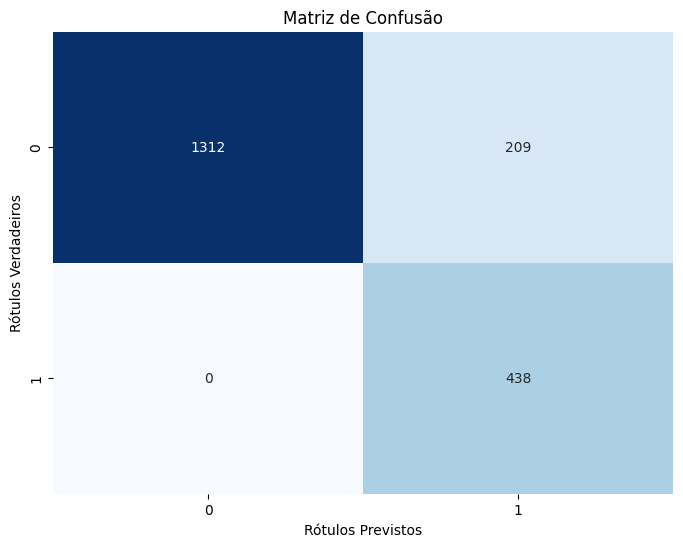

Accuracy: 0.8933129147524247
Precision: 0.6769706336939721
Recall: 1.0
F1-score: 0.8073732718894009
ROC AUC: 0.9312952005259698

Matriz de confusão para o folder 3


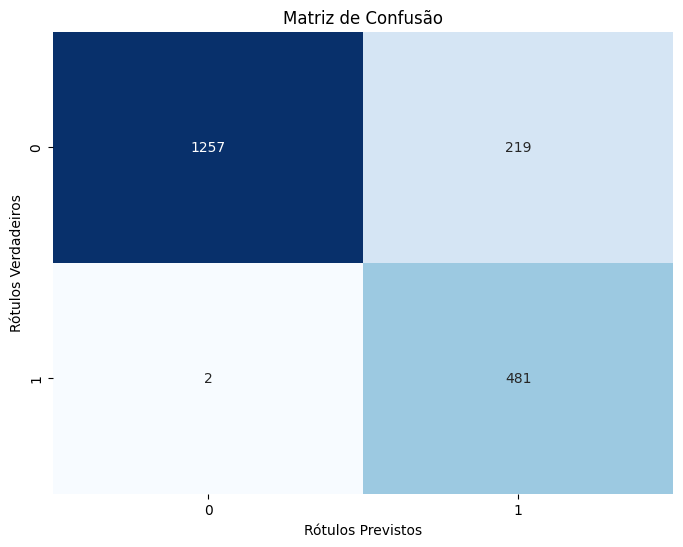

Accuracy: 0.8871873404798366
Precision: 0.6871428571428572
Recall: 0.9958592132505176
F1-score: 0.8131868131868132
ROC AUC: 0.92374261475534

Matriz de confusão para o folder 4


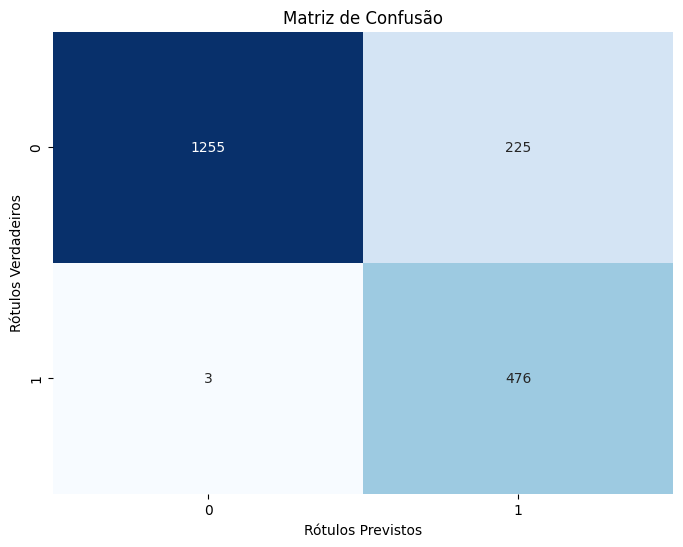

Accuracy: 0.8836140888208269
Precision: 0.6790299572039943
Recall: 0.9937369519832986
F1-score: 0.8067796610169492
ROC AUC: 0.9208549624781358

--------Métricas gerais (média) para a predição dos 5 folders--------:
Accuracy: 0.8884352352761049
Precision: 0.6786875554241797
Recall: 0.9973935708079931
F1-score: 0.8077396657871593
ROC AUC: 0.9261817753973254
MSE: 0.11156476472389507
RMSE: 0.334013120586445


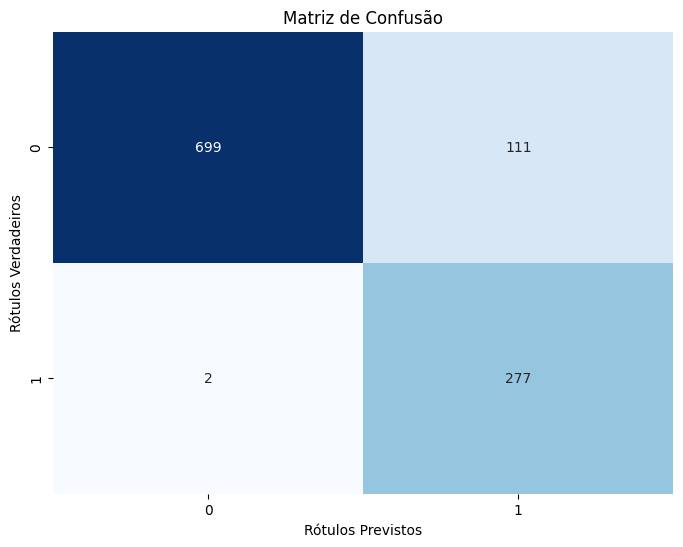


--------Cálculo das métricas do melhor modelo--------:
Accuracy: 0.8962350780532599
Precision: 0.7139175257731959
Recall: 0.992831541218638
F1-score: 0.830584707646177
ROC AUC: 0.9278972520908005
MSE: 0.10376492194674013
RMSE: 0.32212563068892874



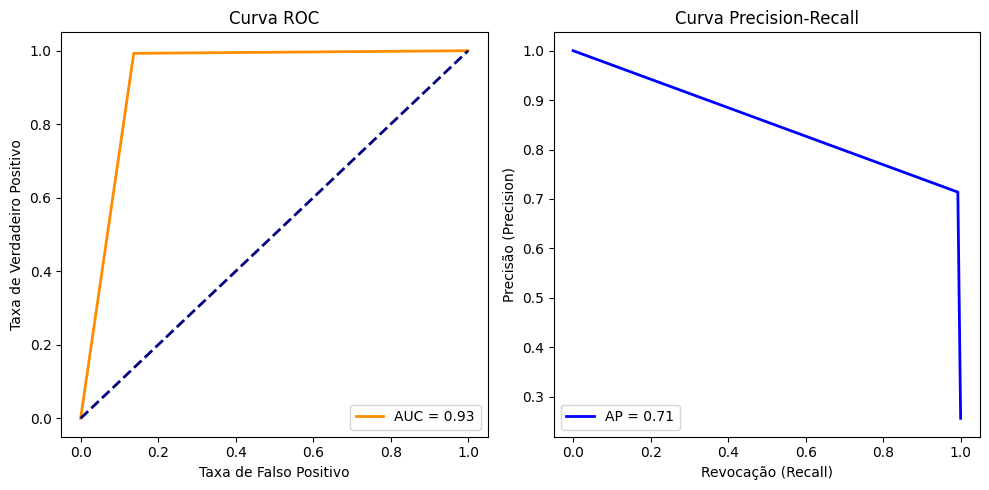

In [188]:
from sklearn.naive_bayes import MultinomialNB
bayes_model = MultinomialNB()

best_bayes_model = train_and_metrics(bayes_model, X_train, y_train, X_test, y_test)

In [189]:
# scaler = StandardScaler()
# X_train_normalized = scaler.fit_transform(X_train)

In [190]:
# X_train_normalized.shape

In [191]:
y_train

10805    1
133      0
3815     0
6739     0
10507    0
        ..
9116     0
10735    1
6186     0
10841    0
613      0
Name: demand_class, Length: 9797, dtype: int64

### Convolucional

In [192]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [193]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

(9797, 13, 1)

In [194]:
name_checkpoint_best_model = 'best_model.h5'

In [195]:
X_train.shape, y_train.shape

((9797, 13, 1), (9797,))

In [196]:
!pip install tensorflow_addons

import tensorflow_addons as tfa
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # soma dos verdadeiros positivos
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # soma dos verdadeiros positivos + falsos negativos
    recall = true_positives / (possible_positives + K.epsilon()) # cálculo do recall
    return recall

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1))) # soma dos verdadeiros negativos
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1))) # soma dos verdadeiros negativos + falsos positivos
    specificity = true_negatives / (possible_negatives + K.epsilon()) # cálculo da especificidade
    return specificity

In [197]:
X_train.shape

(9797, 13, 1)

Epoch 1/20
244/245 [============================>.] - ETA: 0s - loss: 0.2371 - mae: 0.1699 - accuracy: 1.0000 - Recall: 0.6507 - Precision: 0.9204 - Specificity: 0.9981 - AUC: 0.9551
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 4s 8ms/step - loss: 0.2365 - mae: 0.1695 - accuracy: 1.0000 - Recall: 0.6513 - Precision: 0.9206 - Specificity: 0.9981 - AUC: 0.9552 - val_loss: 0.0691 - val_mae: 0.0540 - val_accuracy: 1.0000 - val_Recall: 0.9161 - val_Precision: 0.9932 - val_Specificity: 1.0000 - val_AUC: 0.9984
Epoch 2/20
 36/245 [===>..........................] - ETA: 0s - loss: 0.0696 - mae: 0.0528 - accuracy: 1.0000 - Recall: 0.9386 - Precision: 0.9594 - Specificity: 1.0000 - AUC: 0.9973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - ETA: 0s - loss: 0.0574 - mae: 0.0430 - accuracy: 1.0000 - Recall: 0.9512 - Precision: 0.9638 - Specificity: 1.0000 - AUC: 0.9980
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 2s 8ms/step - loss: 0.0574 - mae: 0.0430 - accuracy: 1.0000 - Recall: 0.9512 - Precision: 0.9638 - Specificity: 1.0000 - AUC: 0.9980 - val_loss: 0.0441 - val_mae: 0.0345 - val_accuracy: 1.0000 - val_Recall: 0.9539 - val_Precision: 0.9764 - val_Specificity: 1.0000 - val_AUC: 0.9992
Epoch 3/20
244/245 [============================>.] - ETA: 0s - loss: 0.0421 - mae: 0.0302 - accuracy: 1.0000 - Recall: 0.9583 - Precision: 0.9664 - Specificity: 1.0000 - AUC: 0.9987
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 2s 10ms/step - loss: 0.0425 - mae: 0.0304 - accuracy: 1.0000 - Recall: 0.9585 - Precision: 0.9656 - Specificity: 1.0000 - AUC: 0.9987 - val_loss: 0.0890 - val_mae: 0.0490 - va

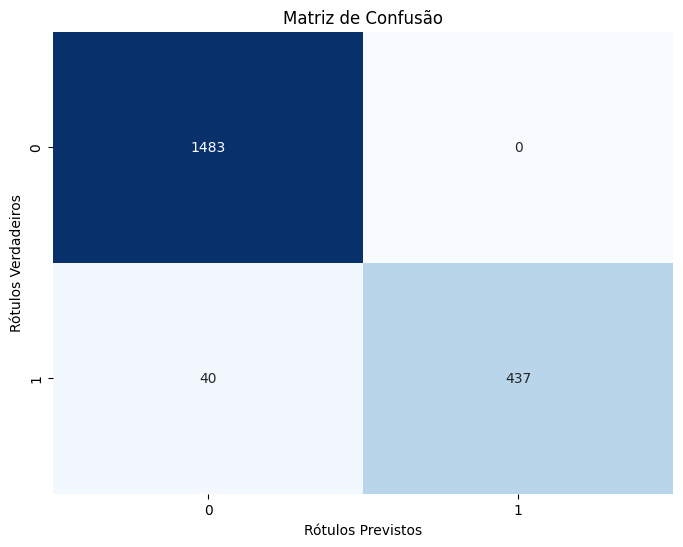

Accuracy: 0.9795918367346939
Precision: 1.0
Recall: 0.9161425576519916
F1-score: 0.9562363238512035
ROC AUC: 0.9580712788259957
MSE: 0.02040816326530612
RMSE: 0.14285714285714285
Epoch 1/20
241/245 [============================>.] - ETA: 0s - loss: 0.2369 - mae: 0.1696 - accuracy: 1.0000 - Recall: 0.6510 - Precision: 0.9278 - Specificity: 0.9969 - AUC: 0.9551
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 3s 6ms/step - loss: 0.2345 - mae: 0.1678 - accuracy: 1.0000 - Recall: 0.6551 - Precision: 0.9293 - Specificity: 0.9971 - AUC: 0.9561 - val_loss: 0.0644 - val_mae: 0.0518 - val_accuracy: 1.0000 - val_Recall: 0.9622 - val_Precision: 0.9642 - val_Specificity: 1.0000 - val_AUC: 0.9986
Epoch 2/20
 40/245 [===>..........................] - ETA: 0s - loss: 0.0735 - mae: 0.0550 - accuracy: 1.0000 - Recall: 0.9331 - Precision: 0.9490 - Specificity: 1.0000 - AUC: 0.9966

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/245 [============================>.] - ETA: 0s - loss: 0.0651 - mae: 0.0476 - accuracy: 1.0000 - Recall: 0.9347 - Precision: 0.9550 - Specificity: 1.0000 - AUC: 0.9972
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0646 - mae: 0.0473 - accuracy: 1.0000 - Recall: 0.9354 - Precision: 0.9555 - Specificity: 1.0000 - AUC: 0.9972 - val_loss: 0.0519 - val_mae: 0.0383 - val_accuracy: 1.0000 - val_Recall: 0.9958 - val_Precision: 0.9368 - val_Specificity: 1.0000 - val_AUC: 0.9993
Epoch 3/20
242/245 [============================>.] - ETA: 0s - loss: 0.0406 - mae: 0.0310 - accuracy: 1.0000 - Recall: 0.9645 - Precision: 0.9681 - Specificity: 1.0000 - AUC: 0.9991
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0405 - mae: 0.0308 - accuracy: 1.0000 - Recall: 0.9643 - Precision: 0.9684 - Specificity: 1.0000 - AUC: 0.9991 - val_loss: 0.0462 - val_mae: 0.0297 - val

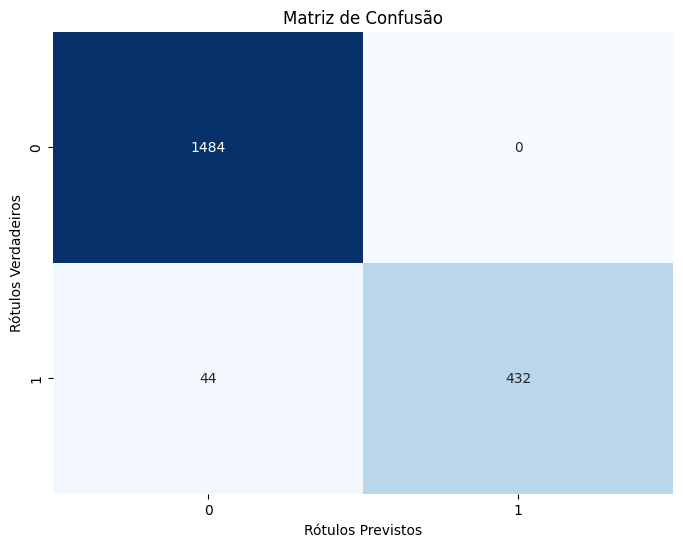

Accuracy: 0.9775510204081632
Precision: 1.0
Recall: 0.907563025210084
F1-score: 0.9515418502202644
ROC AUC: 0.953781512605042
MSE: 0.022448979591836733
RMSE: 0.14982983545287878
Epoch 1/20
239/245 [============================>.] - ETA: 0s - loss: 0.2102 - mae: 0.1528 - accuracy: 1.0000 - Recall: 0.6943 - Precision: 0.9291 - Specificity: 0.9991 - AUC: 0.9677
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 4s 10ms/step - loss: 0.2067 - mae: 0.1503 - accuracy: 1.0000 - Recall: 0.6976 - Precision: 0.9300 - Specificity: 0.9995 - AUC: 0.9687 - val_loss: 0.0595 - val_mae: 0.0479 - val_accuracy: 1.0000 - val_Recall: 0.9580 - val_Precision: 0.9785 - val_Specificity: 1.0000 - val_AUC: 0.9989
Epoch 2/20
 20/245 [=>............................] - ETA: 1s - loss: 0.0655 - mae: 0.0516 - accuracy: 1.0000 - Recall: 0.9647 - Precision: 0.9480 - Specificity: 1.0000 - AUC: 0.9982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/245 [============================>.] - ETA: 0s - loss: 0.0613 - mae: 0.0432 - accuracy: 1.0000 - Recall: 0.9369 - Precision: 0.9546 - Specificity: 1.0000 - AUC: 0.9972
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 2s 6ms/step - loss: 0.0609 - mae: 0.0430 - accuracy: 1.0000 - Recall: 0.9370 - Precision: 0.9551 - Specificity: 1.0000 - AUC: 0.9973 - val_loss: 0.0420 - val_mae: 0.0328 - val_accuracy: 1.0000 - val_Recall: 0.9895 - val_Precision: 0.9632 - val_Specificity: 1.0000 - val_AUC: 0.9993
Epoch 3/20
243/245 [============================>.] - ETA: 0s - loss: 0.0433 - mae: 0.0305 - accuracy: 1.0000 - Recall: 0.9615 - Precision: 0.9681 - Specificity: 1.0000 - AUC: 0.9986
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0430 - mae: 0.0303 - accuracy: 1.0000 - Recall: 0.9617 - Precision: 0.9683 - Specificity: 1.0000 - AUC: 0.9986 - val_loss: 0.0517 - val_mae: 0.0321 - val

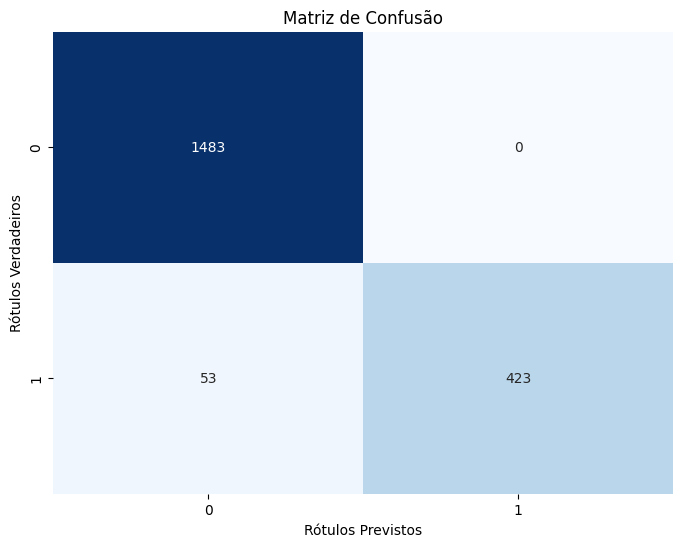

Accuracy: 0.9729453802960695
Precision: 1.0
Recall: 0.8886554621848739
F1-score: 0.9410456062291435
ROC AUC: 0.944327731092437
MSE: 0.027054619703930576
RMSE: 0.16448288574782052
Epoch 1/20
240/245 [============================>.] - ETA: 0s - loss: 0.2170 - mae: 0.1564 - accuracy: 1.0000 - Recall: 0.6876 - Precision: 0.9295 - Specificity: 0.9998 - AUC: 0.9624
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 4s 9ms/step - loss: 0.2137 - mae: 0.1542 - accuracy: 1.0000 - Recall: 0.6950 - Precision: 0.9311 - Specificity: 0.9998 - AUC: 0.9638 - val_loss: 0.0771 - val_mae: 0.0595 - val_accuracy: 1.0000 - val_Recall: 0.9979 - val_Precision: 0.9013 - val_Specificity: 1.0000 - val_AUC: 0.9990
Epoch 2/20
 19/245 [=>............................] - ETA: 1s - loss: 0.0770 - mae: 0.0527 - accuracy: 1.0000 - Recall: 0.9220 - Precision: 0.9489 - Specificity: 1.0000 - AUC: 0.9951

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/245 [============================>.] - ETA: 0s - loss: 0.0602 - mae: 0.0430 - accuracy: 1.0000 - Recall: 0.9437 - Precision: 0.9569 - Specificity: 1.0000 - AUC: 0.9974
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 2s 6ms/step - loss: 0.0604 - mae: 0.0431 - accuracy: 1.0000 - Recall: 0.9444 - Precision: 0.9554 - Specificity: 1.0000 - AUC: 0.9974 - val_loss: 0.0369 - val_mae: 0.0297 - val_accuracy: 1.0000 - val_Recall: 0.9580 - val_Precision: 0.9956 - val_Specificity: 1.0000 - val_AUC: 0.9997
Epoch 3/20
237/245 [============================>.] - ETA: 0s - loss: 0.0485 - mae: 0.0335 - accuracy: 1.0000 - Recall: 0.9529 - Precision: 0.9623 - Specificity: 1.0000 - AUC: 0.9982
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0476 - mae: 0.0329 - accuracy: 1.0000 - Recall: 0.9533 - Precision: 0.9634 - Specificity: 1.0000 - AUC: 0.9983 - val_loss: 0.0411 - val_mae: 0.0273 - val

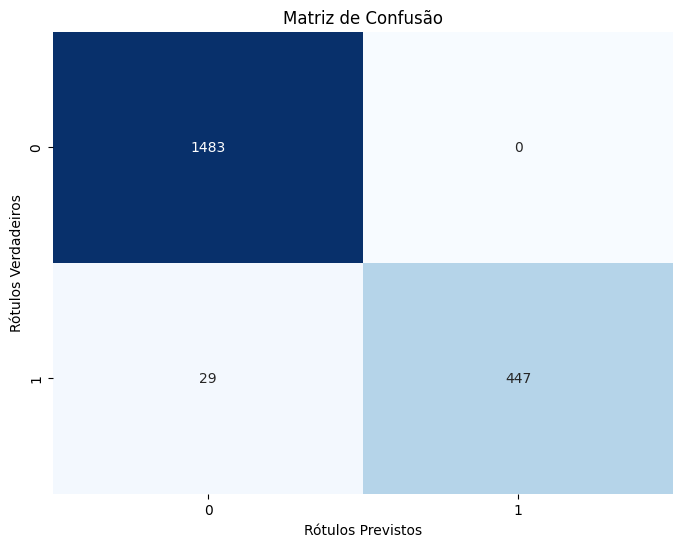

Accuracy: 0.9851965288412455
Precision: 1.0
Recall: 0.9390756302521008
F1-score: 0.9685807150595883
ROC AUC: 0.9695378151260504
MSE: 0.014803471158754467
RMSE: 0.12166951614416187
Epoch 1/20
235/245 [===========================>..] - ETA: 0s - loss: 0.2293 - mae: 0.1639 - accuracy: 1.0000 - Recall: 0.6643 - Precision: 0.9328 - Specificity: 0.9991 - AUC: 0.9559
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 3s 7ms/step - loss: 0.2235 - mae: 0.1597 - accuracy: 1.0000 - Recall: 0.6777 - Precision: 0.9335 - Specificity: 0.9993 - AUC: 0.9583 - val_loss: 0.0602 - val_mae: 0.0488 - val_accuracy: 1.0000 - val_Recall: 0.9853 - val_Precision: 0.9475 - val_Specificity: 1.0000 - val_AUC: 0.9992
Epoch 2/20
 21/245 [=>............................] - ETA: 1s - loss: 0.0695 - mae: 0.0543 - accuracy: 1.0000 - Recall: 0.9494 - Precision: 0.9615 - Specificity: 1.0000 - AUC: 0.9979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/245 [============================>.] - ETA: 0s - loss: 0.0600 - mae: 0.0432 - accuracy: 1.0000 - Recall: 0.9453 - Precision: 0.9588 - Specificity: 1.0000 - AUC: 0.9975
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0593 - mae: 0.0428 - accuracy: 1.0000 - Recall: 0.9470 - Precision: 0.9591 - Specificity: 1.0000 - AUC: 0.9976 - val_loss: 0.0475 - val_mae: 0.0338 - val_accuracy: 1.0000 - val_Recall: 0.9097 - val_Precision: 1.0000 - val_Specificity: 1.0000 - val_AUC: 0.9998
Epoch 3/20
238/245 [============================>.] - ETA: 0s - loss: 0.0427 - mae: 0.0306 - accuracy: 1.0000 - Recall: 0.9627 - Precision: 0.9685 - Specificity: 1.0000 - AUC: 0.9987
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0425 - mae: 0.0304 - accuracy: 1.0000 - Recall: 0.9622 - Precision: 0.9693 - Specificity: 1.0000 - AUC: 0.9987 - val_loss: 0.0429 - val_mae: 0.0300 - val

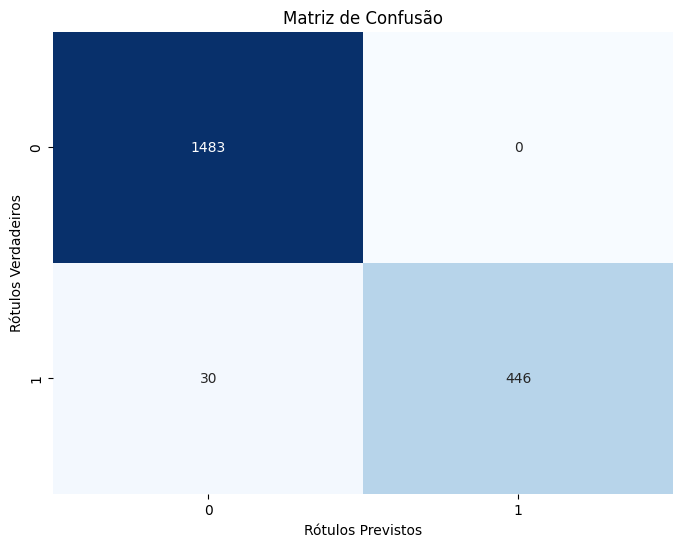

Accuracy: 0.9846860643185299
Precision: 1.0
Recall: 0.9369747899159664
F1-score: 0.9674620390455532
ROC AUC: 0.9684873949579832
MSE: 0.015313935681470138
RMSE: 0.12374948760083873


In [198]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 789)
accuracies = []

# for train_index, test_index in cv.split(X_train, y_train):
#     X_train_neural, X_test_neural = X_train[train_index], X_train[test_index]
#     y_train_neural, y_test_neural = y_train.iloc[train_index], y_train.iloc[test_index]
for n_folder, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_neural, X_test_neural = X_train[train_index], X_train[test_index]
    y_train_neural, y_test_neural = y_train.iloc[train_index], y_train.iloc[test_index]

    model_checkpoint = ModelCheckpoint(name_checkpoint_best_model, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2], )),
        Conv1D(64, 3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics = [ tf.keras.metrics.MeanAbsoluteError(name='mae'),
                                  tf.keras.metrics.CategoricalAccuracy(name='accuracy', dtype=None),
                                  tf.keras.metrics.Recall(name='Recall'),
                                  tf.keras.metrics.Precision(name='Precision'),
                                  tf.keras.metrics.SpecificityAtSensitivity(name='Specificity', sensitivity = 0.5),
                                  tf.keras.metrics.AUC(curve="ROC", summation_method="interpolation", name="AUC")
                                  ])

    model.fit(X_train_neural, y_train_neural, epochs = 20, batch_size = 32,
              validation_data=(X_test_neural, y_test_neural), callbacks=[early_stopping, model_checkpoint], verbose=1 )
    my_tensor = tf.convert_to_tensor(X_test_neural, dtype=tf.float16)
    previsoes = model.predict(my_tensor)

    y_pred_classes = (previsoes > 0.9)
    y_val_classes = np.round(y_test_neural)
    generate_matriz_confusion(y_val_classes, y_pred_classes)
    calcule_metrics_classification(y_val_classes, y_pred_classes)

In [199]:
best_model = keras.models.load_model(name_checkpoint_best_model)

In [200]:
X_test_normalized = scaler.transform(X_test)
y_pred = best_model.predict(X_test_normalized)

y_pred_binary = (y_pred > 0.9).astype(int)

35/35 [==============================] - 0s 2ms/step


In [201]:
print('Métricas gerais (média) para a predição dos 5 folders com Rede Neural:\n')
calcule_metrics_classification(y_test, y_pred_binary)

Métricas gerais (média) para a predição dos 5 folders com Rede Neural:

Accuracy: 0.9412304866850322
Precision: 1.0
Recall: 0.7706093189964157
F1-score: 0.8704453441295545
ROC AUC: 0.8853046594982079
MSE: 0.05876951331496786
RMSE: 0.24242424242424243


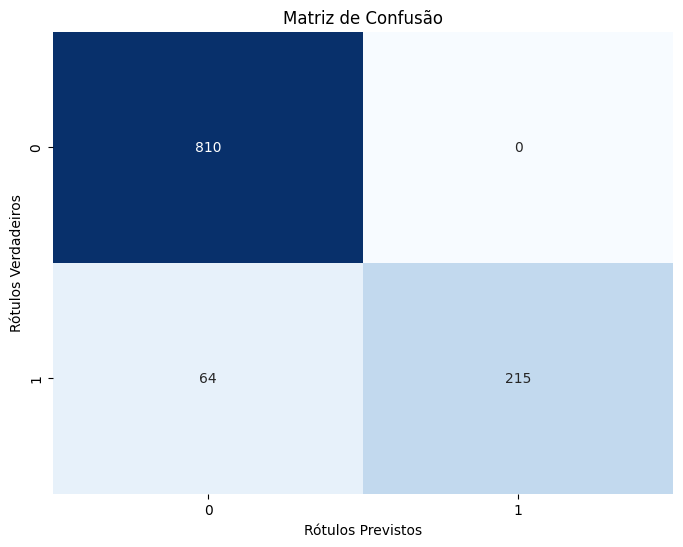

In [202]:
generate_matriz_confusion(y_test, y_pred_binary)